# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [1]:
# code here
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import warnings
warnings.filterwarnings("ignore")
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [2]:
# code here

transform = transforms.Compose([
                    transforms.ToTensor(), 
            ])

trainset =  datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset =  datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=16
                                                    , shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=16 , shuffle=False, num_workers=2)



Files already downloaded and verified
Files already downloaded and verified


torch.Size([16, 3, 32, 32])
torch.Size([16])


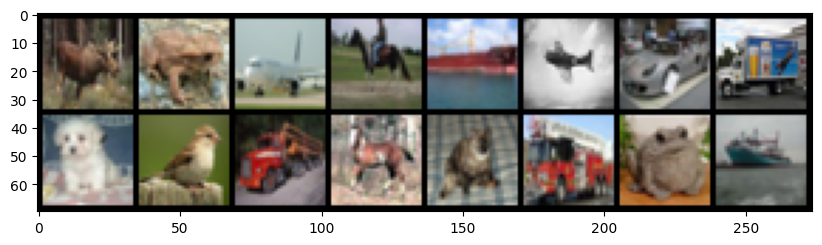

In [3]:
# let's have a look at the dataset
def imshow(img):
    img = img #/ 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(10,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

print(images.shape)
print(labels.shape)

# show images
imshow(torchvision.utils.make_grid(images))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [4]:
class MLPAutoEncoder(nn.Module):
    def __init__(self , rep_size=32):
        super(MLPAutoEncoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: 32
        # Number of Layers for encoder: 3
        # Number of Layers for decoder: 3
        self.encoder = nn.Sequential(
            # flat the data into 3x32x32 -> 3072
            nn.Flatten(), 
            nn.Linear(3072, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, rep_size),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(rep_size, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 3072),
            nn.ReLU(),
            # unflat the data into 3072 -> 3x32x32
            nn.Unflatten(1, (3, 32, 32)), 
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    
    
class ComboAutoEncoder(nn.Module):
    def __init__(self , rep_size=32):
        super(ComboAutoEncoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: 32
        # Number of Layers for encoder: 3
        # Number of Layers for decoder: 3
        self.encoder = nn.Sequential(
            # 3x32x32 -> 16x32x32
            nn.Conv2d(3, 16, 3, stride=1, padding=1), 
            nn.ReLU(),
            # 16x32x32 -> 32x16x16
            nn.Conv2d(16, 32, 3, stride=2, padding=1), 
            nn.ReLU(),
            # 32x16x16 -> 64x8x8
            nn.Conv2d(32, 64, 3, stride=2, padding=1), 
            nn.ReLU(),
            #to flat the data 64x8x8 -> 4096
            nn.Flatten(), 
            nn.Linear(4096, 256), 
            nn.ReLU(),
            nn.Linear(256, rep_size), 
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(rep_size, 256), 
            nn.ReLU(),
            nn.Linear(256, 4096), 
            nn.ReLU(),
            #Unflat the data into 4096 -> 64x8x8
            nn.Unflatten(1, (64, 8, 8)), 
            # 64x8x8 -> 32x16x16
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            # 32x16x16 -> 16x32x32
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            # 16x32x32 -> 3x32x32
            nn.Conv2d(16, 3, 3, stride=1, padding=1), 
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    
class CNNAutoEncoder(nn.Module):
    def __init__(self , rep_size=32):
        super(CNNAutoEncoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: 32
        # Number of Layers for encoder: 3
        # Number of Layers for decoder: 3
        self.encoder = nn.Sequential(
             
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, rep_size, kernel_size=3, stride=2, padding=1),
            nn.ReLU()
         )
            
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(rep_size, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid())
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [5]:
# sample code for a autoencoder:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: 3072
        # Number of Layers for encoder: 1
        # Number of Layers for decoder: 1
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1), # 3x32x32 -> 12x16x16
            nn.ReLU(),
            nn.Flatten(), # 12x16x16 -> 3072
        )
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (12, 16, 16)), # 3072 -> 12x16x16
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), # 12x16x16 -> 3x32x32
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [6]:
def train_encoder( train_loader , epochs , auto_encoder , rep_size=32 ):
    Losses=[]
    Time_taken=[]
    optimizer = torch.optim.Adam(auto_encoder.parameters(), lr=0.001)
    for epoch in range(epochs):
        print("epoch running : ",epoch)
        start_time=time.time()
        loss=0
        for idx , loader in enumerate(train_loader , 0):
            # exctracting input images and labels from data.
            images , labels=loader
            
            optimizer.zero_grad()
            #get encoded, decoded values from auto encoder.
            encoded ,decoded = auto_encoder(images)
            mse_loss = nn.MSELoss()(decoded, images)
            mse_loss.backward()
            optimizer.step()
            loss += mse_loss.item()
            
        Losses.append(loss)
        end_time = time.time()
        total_time = end_time - start_time
        Time_taken.append(total_time) 
    return Losses, Time_taken
            
def test_encoder(test_loader, auto_encoder):
    loss=0
    for idx , loader in enumerate(test_loader , 0):
        # exctracting input images and labels from data.
        images , labels=loader
        
        #get encoded, decoded values from auto encoder.
        encoded ,decoded = auto_encoder(images)
        mse_loss = nn.MSELoss()(decoded, images)
        loss += mse_loss.item()
    loss=loss/len(test_loader)
    return loss
    

In [7]:
# Creating objects of  auto encoders.
mlp_auto_encoder = MLPAutoEncoder()
cnn_auto_encoder = CNNAutoEncoder()
combo_auto_encoder = ComboAutoEncoder()

# set epochs values.
epoch=10

# train encoders.
print("MLP auto encoder running........")
mlp_losses, mlp_time_taken = train_encoder(trainloader , epoch , mlp_auto_encoder ) 


MLP auto encoder running........
epoch running :  0
epoch running :  1
epoch running :  2
epoch running :  3
epoch running :  4
epoch running :  5
epoch running :  6
epoch running :  7
epoch running :  8
epoch running :  9


In [8]:
print("CNN auto encoder running........")
cnn_losses, cnn_time_taken = train_encoder(trainloader , epoch , cnn_auto_encoder ) 


CNN auto encoder running........
epoch running :  0
epoch running :  1
epoch running :  2
epoch running :  3
epoch running :  4
epoch running :  5
epoch running :  6
epoch running :  7
epoch running :  8
epoch running :  9


In [9]:

print("CNN-MLP Combo auto encoder running........")
combo_losses, combo_time_taken = train_encoder(trainloader , epoch , combo_auto_encoder ) 
print("Training completed.")

CNN-MLP Combo auto encoder running........
epoch running :  0
epoch running :  1
epoch running :  2
epoch running :  3
epoch running :  4
epoch running :  5
epoch running :  6
epoch running :  7
epoch running :  8
epoch running :  9
Training completed.


In [10]:
# showing details of each encoder.
print ("-------|  Summary of  MLP Auto Encoder  |--------\n")
summary(mlp_auto_encoder, (3072,))

print ("\n-------|  Summary of  CNN Auto Encoder  |-------\n")
summary(cnn_auto_encoder, (3, 32, 32))

print ("\n-------|  Summary of  CNN-MLP Auto Encoder  |-------\n")
summary(combo_auto_encoder, (3, 32, 32))

-------|  Summary of  MLP Auto Encoder  |--------

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Flatten: 2-1                      [-1, 3072]                --
|    └─Linear: 2-2                       [-1, 256]                 786,688
|    └─ReLU: 2-3                         [-1, 256]                 --
|    └─Linear: 2-4                       [-1, 64]                  16,448
|    └─ReLU: 2-5                         [-1, 64]                  --
|    └─Linear: 2-6                       [-1, 32]                  2,080
|    └─ReLU: 2-7                         [-1, 32]                  --
├─Sequential: 1-2                        [-1, 3, 32, 32]           --
|    └─Linear: 2-8                       [-1, 64]                  2,112
|    └─ReLU: 2-9                         [-1, 64]                  --
|    └─Linear: 2-10                      [-1, 256]                 16,640
|    └─ReLU: 2-

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 32]                  --
|    └─Conv2d: 2-1                       [-1, 16, 32, 32]          448
|    └─ReLU: 2-2                         [-1, 16, 32, 32]          --
|    └─Conv2d: 2-3                       [-1, 32, 16, 16]          4,640
|    └─ReLU: 2-4                         [-1, 32, 16, 16]          --
|    └─Conv2d: 2-5                       [-1, 64, 8, 8]            18,496
|    └─ReLU: 2-6                         [-1, 64, 8, 8]            --
|    └─Flatten: 2-7                      [-1, 4096]                --
|    └─Linear: 2-8                       [-1, 256]                 1,048,832
|    └─ReLU: 2-9                         [-1, 256]                 --
|    └─Linear: 2-10                      [-1, 32]                  8,224
|    └─ReLU: 2-11                        [-1, 32]                  --
├─Sequential: 1-2                        [-1, 3, 32, 32]           

In [11]:
# Time taken for each epoch in model.
Column_s=[" Model "]

for i in range(epoch):
    Column_s.append("epoch"+str(i+1))
mlp_row = ["MLP Encoder"]
cnn_row = ["CNN Encoder"]
combo_row = ["CNN-MLP Encoder"]

for t in mlp_time_taken:
    mlp_row.append(t)
    
for t in cnn_time_taken:
    cnn_row.append(t)
    
for t in combo_time_taken:
    combo_row.append(t)

rows=[mlp_row, cnn_row, combo_row]

results = pd.DataFrame(rows, columns=Column_s)

print("Time taken by each model in each epoch : \n",results)

Time taken by each model in each epoch : 
             Model      epoch1     epoch2     epoch3     epoch4     epoch5  \
0      MLP Encoder  29.830276  29.448176  29.612429  29.321448  29.510041   
1      CNN Encoder  47.626097  47.641528  41.669856  39.897818  40.207424   
2  CNN-MLP Encoder  95.448692  97.750218  98.009726  97.863614  98.110718   

      epoch6     epoch7      epoch8      epoch9     epoch10  
0  29.565078  29.586202   29.557638   29.567352   29.585869  
1  39.894175  39.904675   39.921703   39.941364   39.878222  
2  97.963769  98.593104  100.028701  102.782203  101.040806  


In [12]:
def plot_graph(loss1,loss2,loss3,x):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Epoch vs Loss in all Models')
    plt.plot(x , loss1 , marker='o', label='MLP Losses')
    plt.plot(x , loss2 , marker='o', label='CNN Losses')
    plt.plot(x , loss3 , marker='o', label='CNN-MLP Losses')
    plt.legend()
    plt.show()

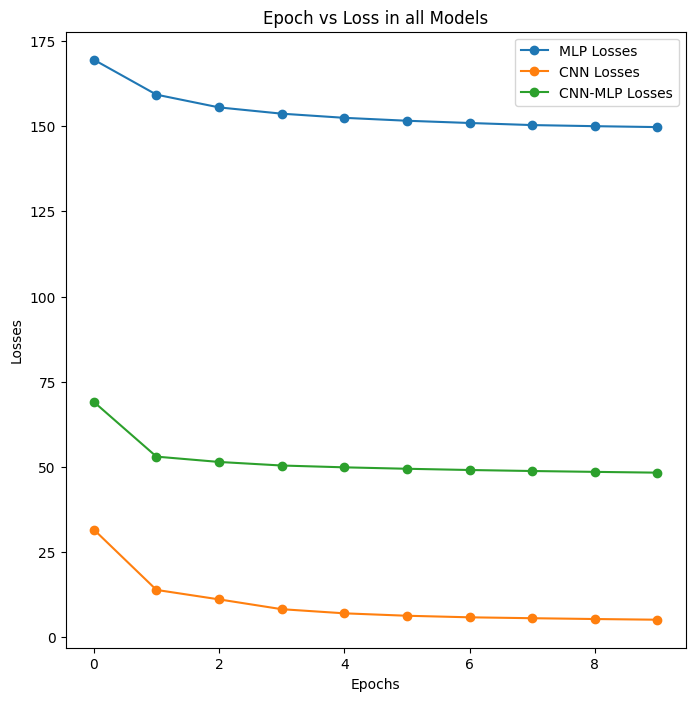

In [13]:
plot_graph(mlp_losses,cnn_losses,combo_losses,[i for i in range(epoch)])

In [14]:
# Loss on test data.
def get_param_count( model ):
    param_count = 0
    for param in model.parameters():
        param_count += param.numel()
    return param_count


In [15]:
#get test losses

mlp_test_loss=test_encoder(testloader, mlp_auto_encoder)
cnn_test_loss=test_encoder(testloader, cnn_auto_encoder)
combo_test_loss=test_encoder(testloader, combo_auto_encoder)

In [16]:
mlp_params=get_param_count(mlp_auto_encoder)
cnn_params=get_param_count(cnn_auto_encoder)
combo_params=get_param_count(combo_auto_encoder)


Column_s=[" Model ", "parameters", "Loss"]

mlp_row1 = ["MLP Encoder",mlp_params, mlp_test_loss ]
cnn_row1 = ["CNN Encoder",cnn_params, cnn_test_loss]
combo_row1 = ["CNN-MLP Encoder",combo_params, combo_test_loss]

rows=[mlp_row1, cnn_row1, combo_row1]

results = pd.DataFrame(rows, columns=Column_s)

print("Test losses : \n",results)

Test losses : 
             Model   parameters      Loss
0      MLP Encoder     1613472  0.047382
1      CNN Encoder       28643  0.001600
2  CNN-MLP Encoder     2165283  0.015743


MLP Encoder :--------------------------
GroundTruth:  horse  bird  bird  frog   car


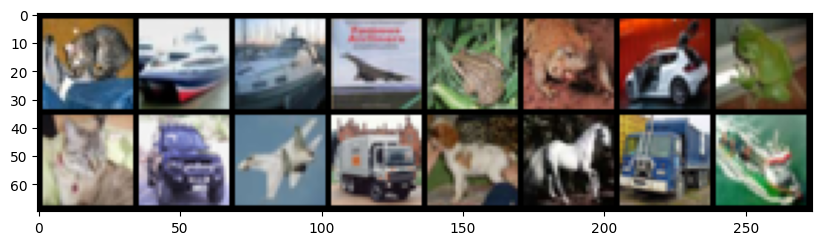

Reconstructed image


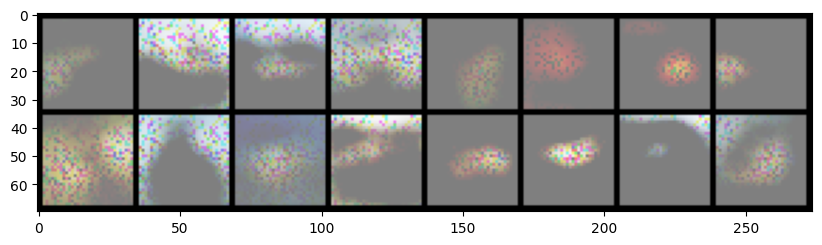

MLP-CNN Encoder :--------------------------
GroundTruth:  horse  bird  bird  frog   car


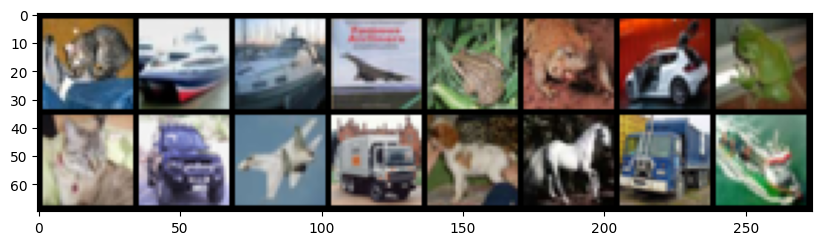

Reconstructed image


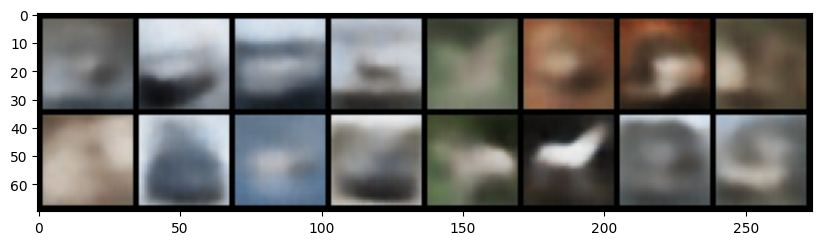

CNN Encoder :--------------------------
GroundTruth:  horse  bird  bird  frog   car


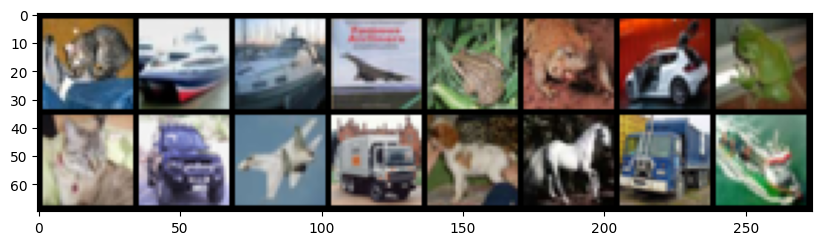

Reconstructed image


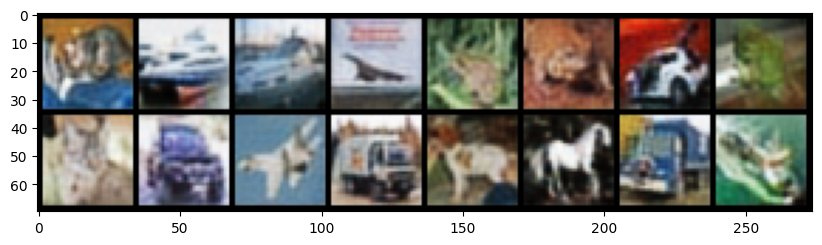

In [17]:
# Utilize the following code

classes = ('frog', 'deer', 'truck' , 'horse', 'ship', 'cat', 'car', 'plane', 'bird', 'dog' )


#--------------MLP--------------#
print("MLP Encoder :--------------------------")
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = mlp_auto_encoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------Combo--------------#
print("MLP-CNN Encoder :--------------------------")

dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = combo_auto_encoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

#--------------CNN--------------#
print("CNN Encoder :--------------------------")

dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = cnn_auto_encoder(images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [18]:
represantation_sizes = [10 , 32 , 100 ,1000]
models_rep = []
losses_rep = []
times_rep = []
for rep_size in represantation_sizes:
    print("CNN auto encoder running with representation sizes : ", rep_size)
    model = CNNAutoEncoder(rep_size)
    losses, time_taken = train_encoder(trainloader , epoch , model )
    models_rep.append(model)
    losses_rep.append(losses)
    times_rep.append(time_taken)

CNN auto encoder running with representation sizes :  10
epoch running :  0
epoch running :  1
epoch running :  2
epoch running :  3
epoch running :  4
epoch running :  5
epoch running :  6
epoch running :  7
epoch running :  8
epoch running :  9
CNN auto encoder running with representation sizes :  32
epoch running :  0
epoch running :  1
epoch running :  2
epoch running :  3
epoch running :  4
epoch running :  5
epoch running :  6
epoch running :  7
epoch running :  8
epoch running :  9
CNN auto encoder running with representation sizes :  100
epoch running :  0
epoch running :  1
epoch running :  2
epoch running :  3
epoch running :  4
epoch running :  5
epoch running :  6
epoch running :  7
epoch running :  8
epoch running :  9
CNN auto encoder running with representation sizes :  1000
epoch running :  0
epoch running :  1
epoch running :  2
epoch running :  3
epoch running :  4
epoch running :  5
epoch running :  6
epoch running :  7
epoch running :  8
epoch running :  9


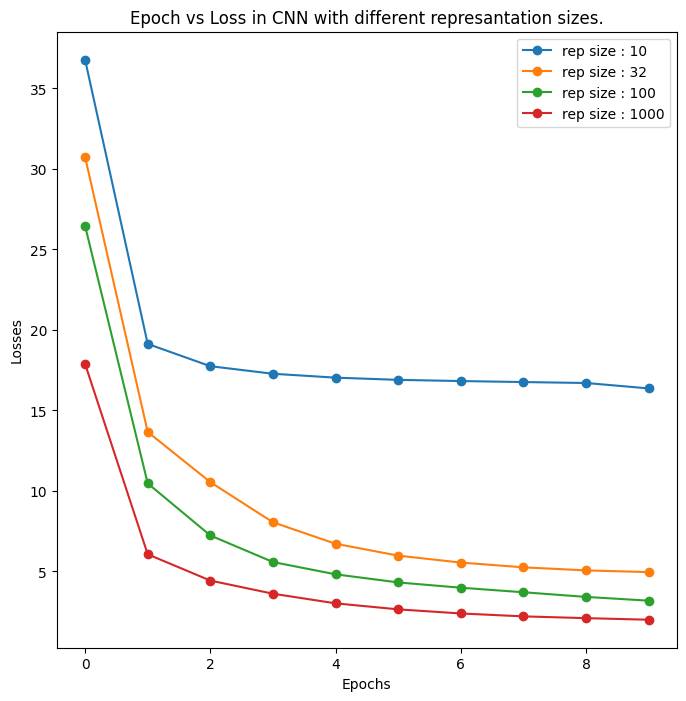

In [19]:
def plot_graph_rep(losses,x):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Epoch vs Loss in CNN with different represantation sizes.')
    plt.plot(x , losses[0] , marker='o', label='rep size : 10')
    plt.plot(x , losses[1] , marker='o', label='rep size : 32')
    plt.plot(x , losses[2] , marker='o', label='rep size : 100')
    plt.plot(x , losses[3] , marker='o', label='rep size : 1000')
    plt.legend()
    plt.show()
    
plot_graph_rep(losses_rep,[i for i in range(epoch)])

In [20]:
# Time taken for each epoch in model.
Column_s=[" represantation size "]

for i in range(epoch):
    Column_s.append("epoch"+str(i+1))
row_10 = [10]
row_32 = [32]
row_100 = [100]
row_1000 = [1000]

for t in times_rep[0]:
    row_10.append(t)
    
for t in times_rep[1]:
    row_32.append(t)
    
for t in times_rep[2]:
    row_100.append(t)
    
for t in times_rep[3]:
    row_1000.append(t)

rows=[row_10, row_32, row_100, row_1000 ]

results = pd.DataFrame(rows, columns=Column_s)

print("Time taken by  models in each epoch : \n",results)

Time taken by  models in each epoch : 
     represantation size      epoch1      epoch2      epoch3     epoch4  \
0                     10  39.239252   39.358868   39.301338  39.292873   
1                     32  40.289883   40.623411   40.293832  40.856667   
2                    100  46.379452   44.977188   44.997373  46.273813   
3                   1000  99.353670  100.792367  100.329772  99.955308   

      epoch5     epoch6     epoch7     epoch8     epoch9    epoch10  
0  39.706696  39.390245  39.003433  39.283007  39.226573  38.908572  
1  41.561488  41.602704  42.805838  40.468918  42.277307  40.193391  
2  48.430634  51.701921  50.189848  48.341268  49.350567  49.813810  
3  87.933052  89.052881  88.673358  89.575737  89.273846  90.153557  


CNN Encoder with represantation size-10 :--------------------------
GroundTruth:  horse  bird  bird  frog   car


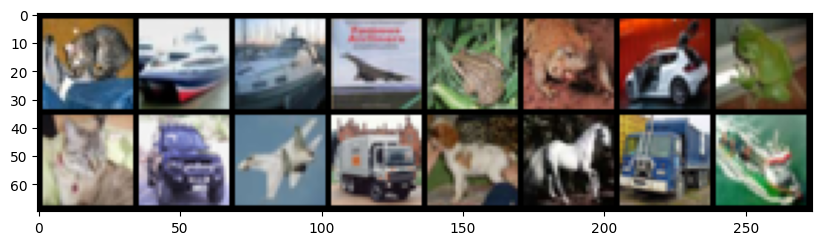

Reconstructed image


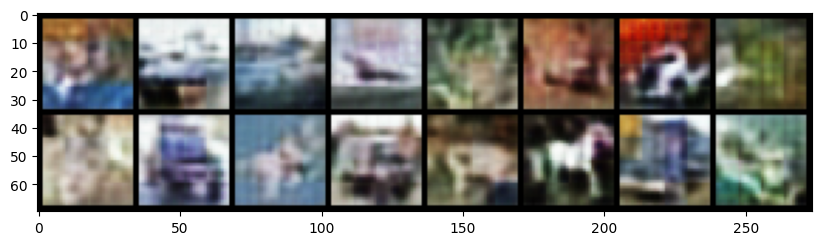

CNN Encoder with represantation size-32 :--------------------------
GroundTruth:  horse  bird  bird  frog   car


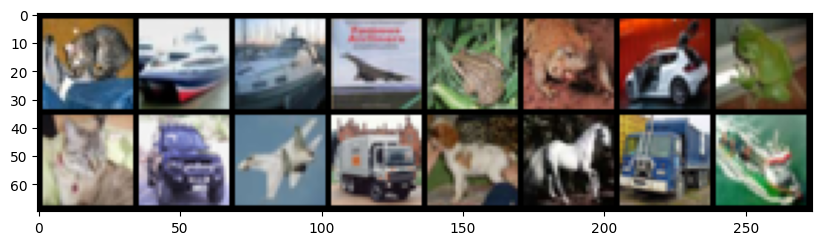

Reconstructed image


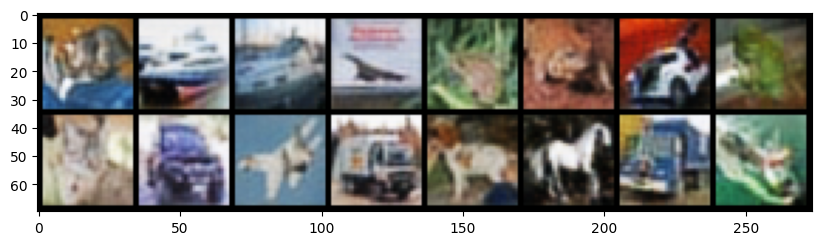

CNN Encoder with represantation size-100 :--------------------------
GroundTruth:  horse  bird  bird  frog   car


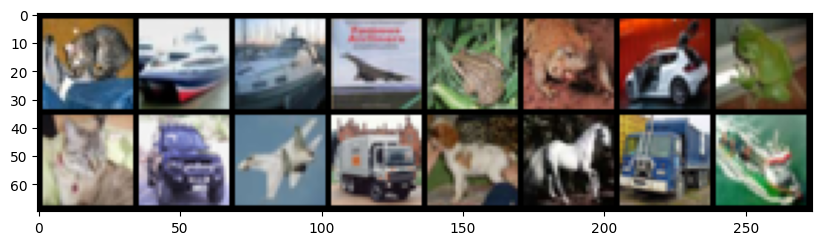

Reconstructed image


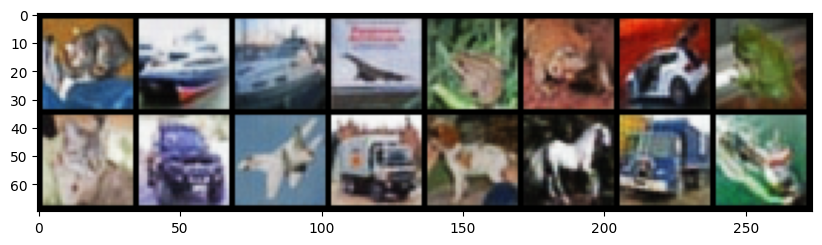

CNN Encoder with represantation size-1000 :--------------------------
GroundTruth:  horse  bird  bird  frog   car


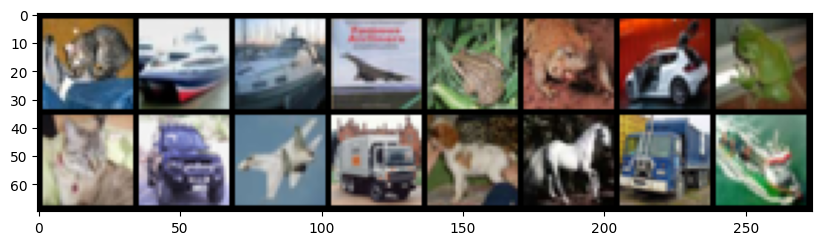

Reconstructed image


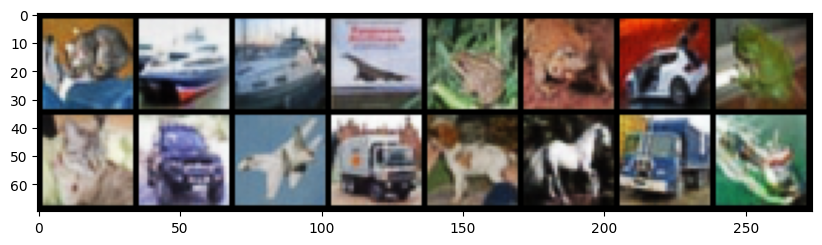

In [21]:

#-------------- Rep_size : 10 CNN --------------#
print("CNN Encoder with represantation size-10 :--------------------------")
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = models_rep[0](images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))


#-------------- Rep_size : 32 CNN --------------#
print("CNN Encoder with represantation size-32 :--------------------------")
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = models_rep[1](images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))


#-------------- Rep_size : 100 CNN --------------#
print("CNN Encoder with represantation size-100 :--------------------------")
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = models_rep[2](images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))


#-------------- Rep_size : 1000 CNN --------------#
print("CNN Encoder with represantation size-1000 :--------------------------")
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = models_rep[3](images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))


### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [22]:
class CNNAutoEncoder_1_layer(nn.Module):
    def __init__(self , rep_size=32):
        super(CNNAutoEncoder_1_layer, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: rep_size
        # Number of Layers for encoder: 1
        # Number of Layers for decoder: 1
        
        self.encoder = nn.Sequential(
            nn.Conv2d(3, rep_size, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
         )
            
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(rep_size, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
            
            
class CNNAutoEncoder_3_layer(nn.Module):
    def __init__(self , rep_size=32):
        super(CNNAutoEncoder_3_layer, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: rep_size
        # Number of Layers for encoder: 3
        # Number of Layers for decoder: 3
            
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, rep_size, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
         )
            
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(rep_size, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

            
class CNNAutoEncoder_5_layer(nn.Module):
    def __init__(self , rep_size=32):
        super(CNNAutoEncoder_5_layer, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: rep_size
        # Number of Layers for encoder: 5
        # Number of Layers for decoder: 5
            
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, rep_size, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
         )
            
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(rep_size, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
            
            
class CNNAutoEncoder_10_layer(nn.Module):
    def __init__(self , rep_size=32):
        super(CNNAutoEncoder_10_layer, self).__init__()
        # Input size: [batch, 3, 32, 32]
        # Output size: [batch, 3, 32, 32]
        # Representation size: rep_size
        # Number of Layers for encoder: 10
        # Number of Layers for decoder: 10
            
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, rep_size, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
         )
            
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(rep_size, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [35]:
epoch = 2
layers_ = [1, 3, 5]
# layers_ = [1, 3, 5,10]
model_1=CNNAutoEncoder_1_layer()
model_3=CNNAutoEncoder_3_layer()
model_5=CNNAutoEncoder_5_layer()
model_10=CNNAutoEncoder_10_layer()
models_ = [model_1, model_3, model_5]
# models_ = [model_1, model_3, model_5,model_10]
losses_ = []
times_taken = []
for layer,model in zip(layers_,models_):
    print("CNN auto encoder running with number of layers : ", layer)
    losses, time_taken = train_encoder(trainloader , epoch , model )
    losses_.append(losses)
    times_taken.append(time_taken)

CNN auto encoder running with number of layers :  1
epoch running :  0
epoch running :  1
CNN auto encoder running with number of layers :  3
epoch running :  0
epoch running :  1
CNN auto encoder running with number of layers :  5
epoch running :  0
epoch running :  1


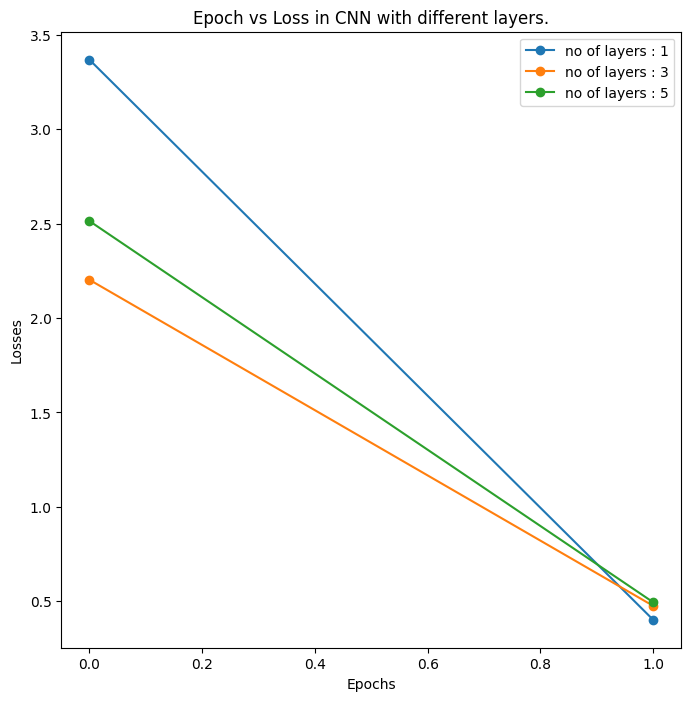

In [36]:
def plot_graph_layer(losses,x):
    plt.figure(figsize=(8, 8))
    plt.xlabel('Epochs')
    plt.ylabel('Losses')
    plt.title('Epoch vs Loss in CNN with different layers.')
    plt.plot(x , losses[0] , marker='o', label='no of layers : 1')
    plt.plot(x , losses[1] , marker='o', label='no of layers : 3')
    plt.plot(x , losses[2] , marker='o', label='no of layers : 5')
#     plt.plot(x , losses[3] , marker='o', label='no of layers : 10')
    plt.legend()
    plt.show()
    
plot_graph_layer(losses_, [i for i in range(epoch)])

In [37]:
# Time taken for each epoch in model.
Column_s=[" represantation size "]

for i in range(epoch):
    Column_s.append("epoch"+str(i+1))
row_1 = [10]
row_3 = [32]
row_5 = [100]
# row_10 = [1000]

for t in times_taken[0]:
    row_1.append(t)
    
for t in times_taken[1]:
    row_3.append(t)
    
for t in times_taken[2]:
    row_5.append(t)
    
# for t in times_taken[3]:
#     row_10.append(t)

rows=[row_1, row_3, row_5]
# rows=[row_1, row_3, row_5, row_10]

results = pd.DataFrame(rows, columns=Column_s)

print("Time taken by  models in each epoch : \n",results)

Time taken by  models in each epoch : 
     represantation size       epoch1      epoch2
0                     10    3.475496    3.425859
1                     32   25.558964   26.000141
2                    100  133.278316  139.413236


CNN Encoder with No. of layers : 1 :--------------------------
GroundTruth:   frog  frog  frog  frog  frog


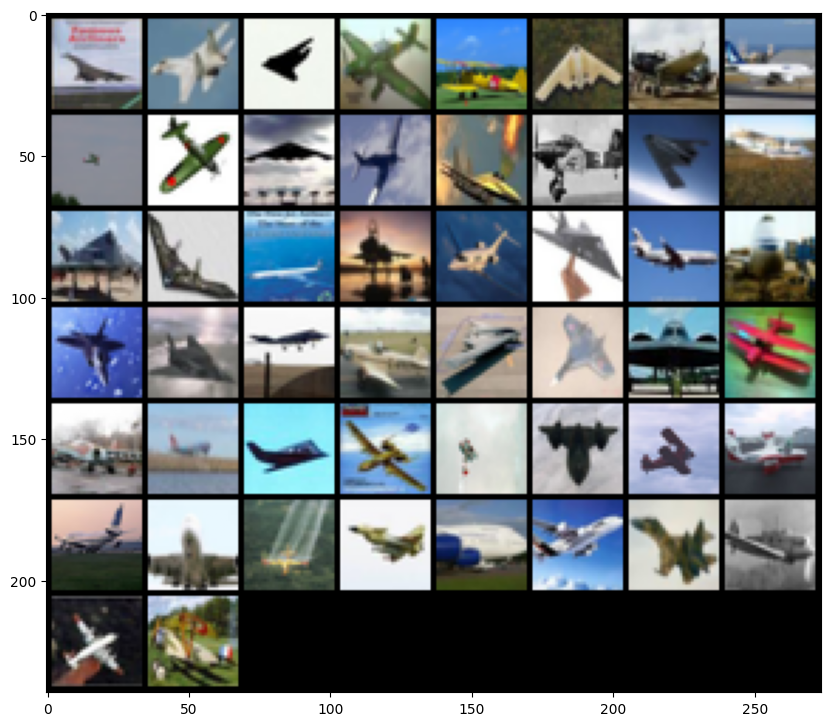

Reconstructed image


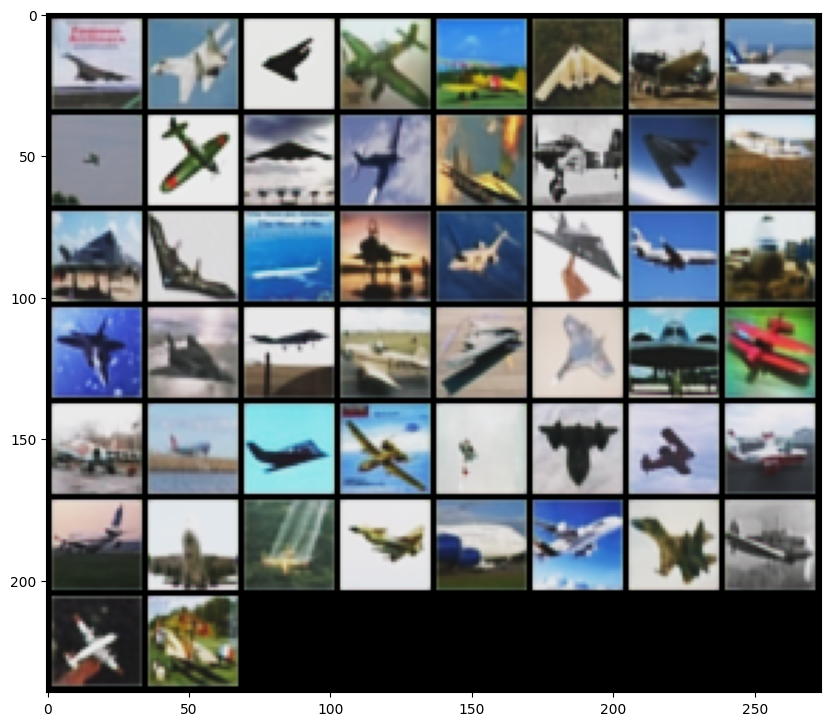

CNN Encoder with No. of layers : 3 :--------------------------
GroundTruth:   frog  frog  frog  frog  frog


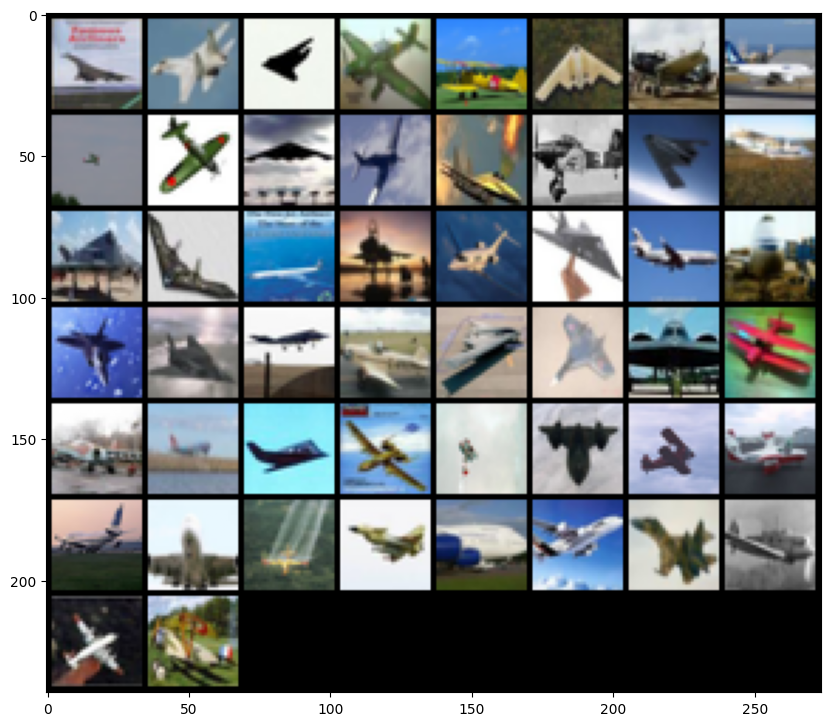

Reconstructed image


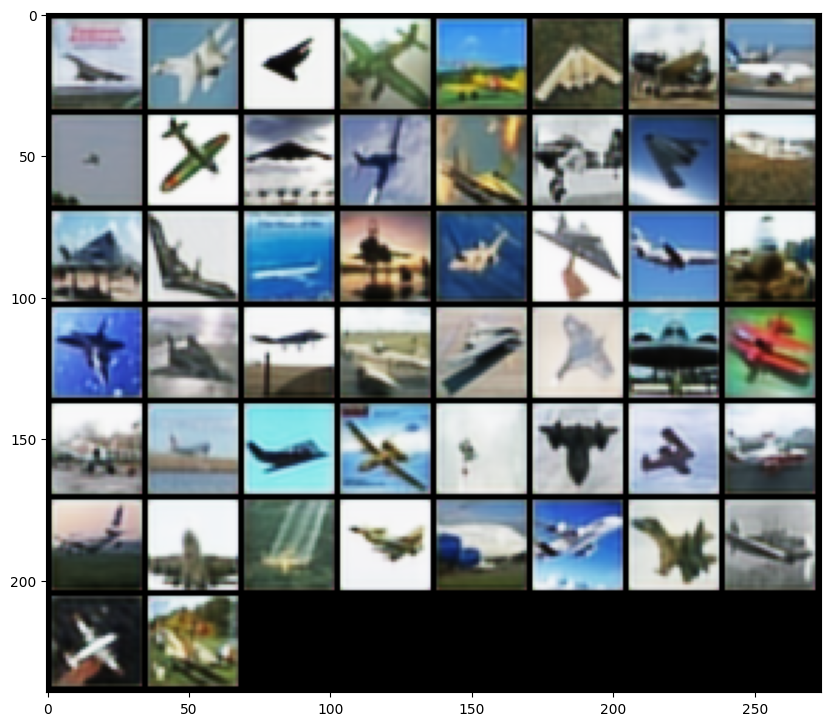

CNN Encoder with No of layers : 5 :--------------------------
GroundTruth:   frog  frog  frog  frog  frog


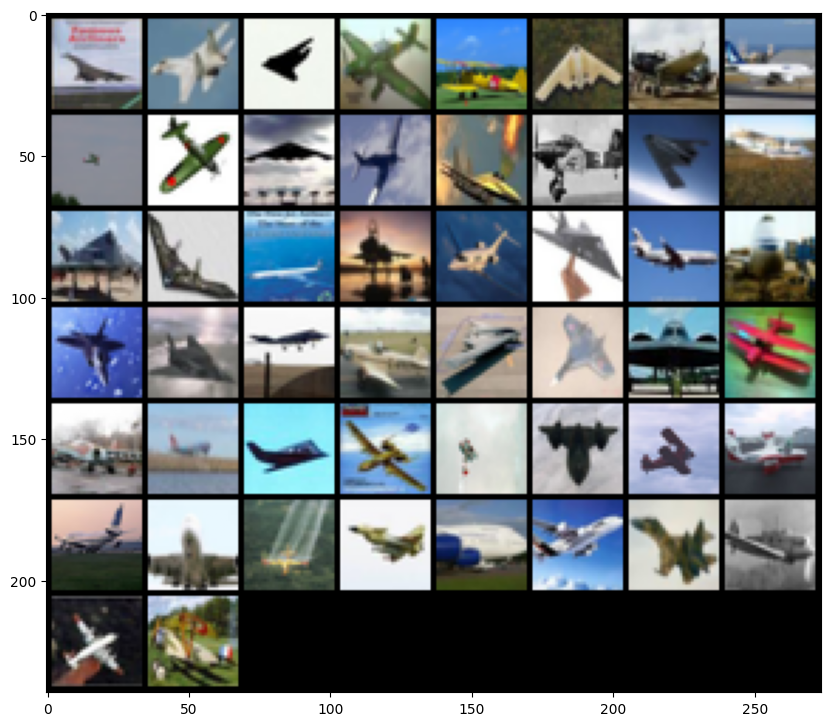

Reconstructed image


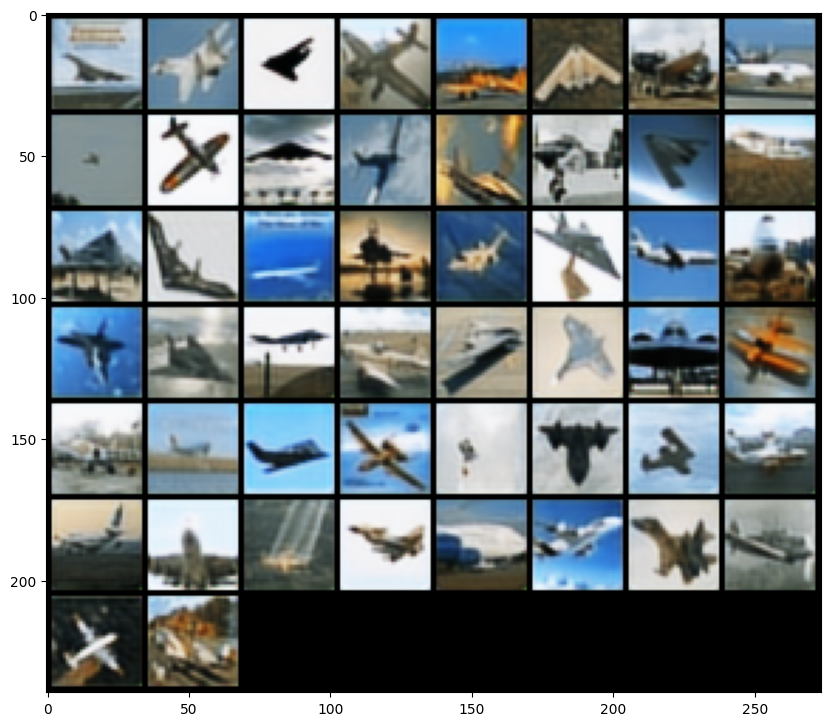

In [38]:

#-------------- No of layers : 1 CNN --------------#
print("CNN Encoder with No. of layers : 1 :--------------------------")
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = models_[0](images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))


#-------------- No of layers : 3 CNN --------------#
print("CNN Encoder with No. of layers : 3 :--------------------------")
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = models_[1](images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))


#-------------- No of layers : 5 CNN --------------#
print("CNN Encoder with No of layers : 5 :--------------------------")
dataiter = iter(testloader)
images, labels = dataiter.__next__()
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
imshow(torchvision.utils.make_grid(images))

images = Variable(images)

print("Reconstructed image")
decoded_imgs = models_[2](images)[1]
imshow(torchvision.utils.make_grid(decoded_imgs.data))


#-------------- No of layers : 10 CNN --------------#
# print("CNN Encoder with No of layers : 10 :--------------------------")
# dataiter = iter(testloader)
# images, labels = dataiter.__next__()
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(5)))
# imshow(torchvision.utils.make_grid(images))

# images = Variable(images)

# print("Reconstructed image")
# decoded_imgs = models_[3](images)[1]
# imshow(torchvision.utils.make_grid(decoded_imgs.data))


### Explaination time!
Please write a short-essay explaining what AutoEncoder does, how it is different from other data-representation methods like PCA, t-SNE and Variational AutoEncoders. Also tell what were your take-outs from this experiment.

### Explaination:
Autoencoder is a type of neural network that learns to encode input data into a lower-dimensional space and then decode it back to the original input with minimal loss. This technique is useful for data compression, data generation. Autoencoders can learn nonlinear relationships between input features, which distinguishes them from other data-representation methods like PCA and t-SNE that only learn linear or nonlinear relationships.<br>
In our experiment we can see cnn auto encoder is performing very well as in the decoder output it genrates with a few loss only. Also we can see the plot of the losses of three of the model , CNN has better performance as compared to both the others.<br>
    When working with different representation sizes(10,32,100,1000) in a CNN auto-encoder, we can see after increasing the represantation size to 100 or 1000 it give same output as with 32 ,It does not lead to significant improvements in reconstruction quality.<br>
    
When experimenting with different numbers of layers(1,3,5,10) in the encoder and decoder of a CNN auto-encoder, we can see adding more layers does not result in significant improvements in reconstruction quality as you said, like in visualization there is not much improvment in 5 layers and 10 layers model.

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [30]:
# code and analysis here. Remember to keep your analysis of high quality at all times.


from sklearn.neighbors import KNeighborsClassifier
import torchvision.transforms as transforms
import torch.autograd as autograd




train_indices = np.concatenate([np.where(np.array(trainset.targets) == i)[0][:1000] for i in range(10)])
train_subset = torch.utils.data.Subset(trainset, train_indices)

test_indices = np.concatenate([np.where(np.array(testset.targets) == i)[0][:100] for i in range(10)])
test_subset = torch.utils.data.Subset(testset, test_indices)

trainloader = torch.utils.data.DataLoader(train_subset, batch_size=50, shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=50 , shuffle=False)


train_features = []
train_labels = []

#Already  trained model with represantation size : 10
encoder = models_rep[0].encoder

#encoding train features and train labels.
for images, labels in trainloader:
    with torch.no_grad():
        images = autograd.Variable(images)
        encoded = encoder(images)
        encoded= encoded.reshape(encoded.shape[0], -1)

    train_features.append(encoded.detach().numpy())
    train_labels.append(labels.numpy())

train_features = np.concatenate(train_features)
train_labels = np.concatenate(train_labels)


test_features = []
test_labels = []

#encoding test features and test labels.
for images, labels in testloader:
    with torch.no_grad():
        images = autograd.Variable(images)
        encoded = encoder(images)
        encoded= encoded.reshape(encoded.shape[0], -1)

    test_features.append(encoded.detach().numpy())
    test_labels.append(labels.numpy())

test_features = np.concatenate(test_features)
test_labels = np.concatenate(test_labels)


# using KNeighborsClassifier and evaluating accuracy with different k values.

k_values = [ 20 , 30 , 50 , 100 , 500, 1000]
Accuracies = []

for k in k_values:
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(train_features, train_labels)

    #Evaluate score
    accuracy = clf.score(test_features, test_labels)
    Accuracies.append(accuracy)
    
for k,acc in zip(k_values,Accuracies):
    print("Accuracy on k :" , k , " is : ", acc)

Accuracy on k : 20  is :  0.302
Accuracy on k : 30  is :  0.301
Accuracy on k : 50  is :  0.283
Accuracy on k : 100  is :  0.269
Accuracy on k : 500  is :  0.253
Accuracy on k : 1000  is :  0.246


## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [ ]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [ ]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [ ]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [ ]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."